<a href="https://colab.research.google.com/github/MinhazAkram/ESC50/blob/main/Optimizes_esc50_Minhaz_MFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECS50 signal of 10 class animal sound

#### Classification based on MFCC

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras-tuner


     |████████████████████████████████| 71kB 5.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=f4c97272e0e3034635aaaf6fd4866b1d8fa194777b81ca99e3cdefc62edfaef1
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=b83bd737752ec04216e7ed16395e87d78539ab0c2d5303a6cbaa1f0564bac92a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [5]:
import librosa
import librosa.display
import random
import os
import warnings
warnings.filterwarnings('ignore')

(40, 216)


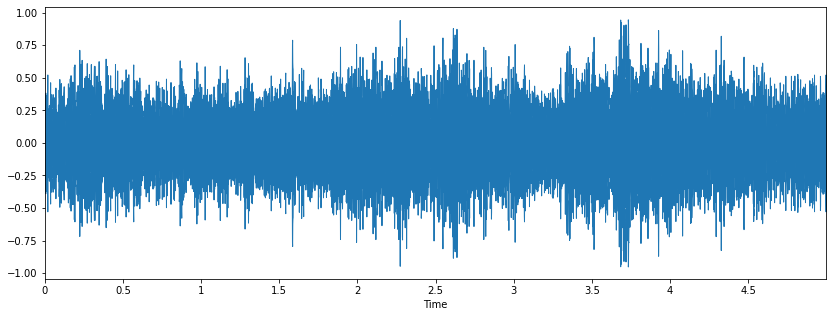

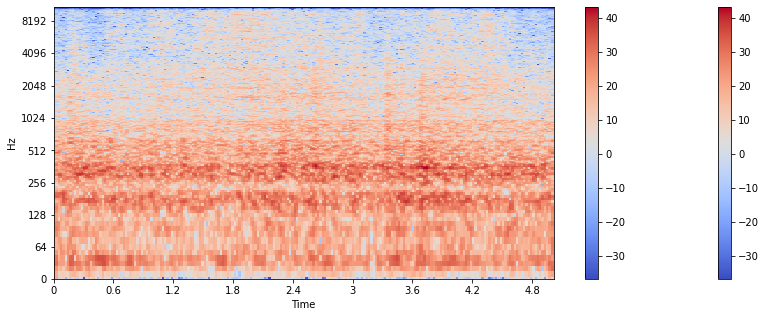

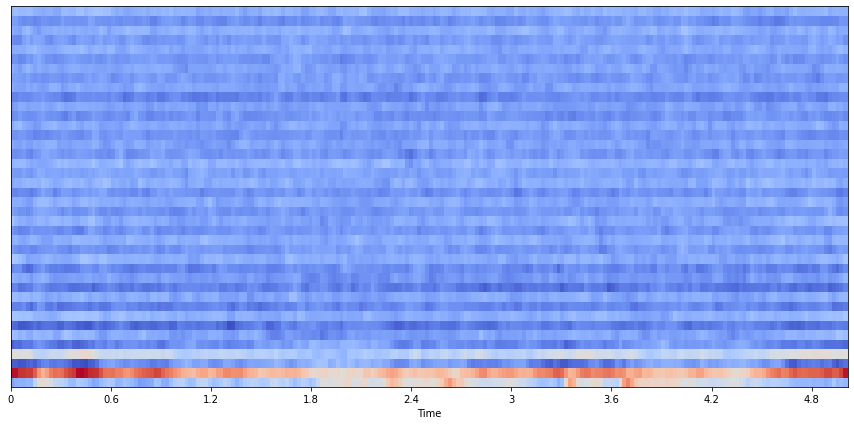

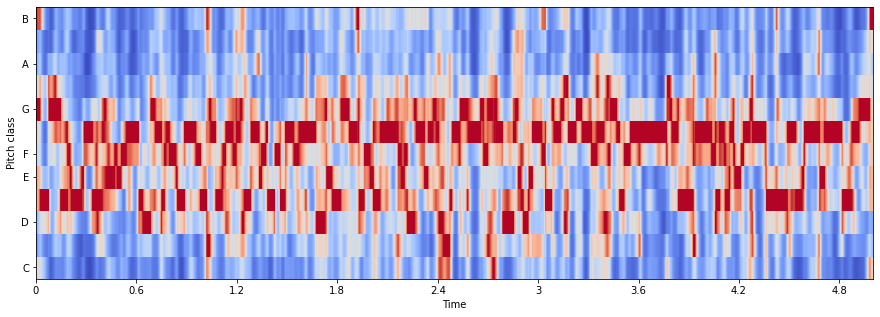

In [6]:
# Example of a Animal spectrogram

y, sr = librosa.load('/content/drive/My Drive/Colab Notebooks/esc50/data/train/5-199284-B-45.wav')
mel_spec = librosa.feature.melspectrogram(y=y, sr= sr)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
mfcc = librosa.feature.mfcc(y , sr=sr , n_mfcc=40, dct_type=3)



#Visualizing Audio:
#We can plot the audio array using librosa.display.waveplot:

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)


#We can display a spectrogram using. librosa.display.specshow.

X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

#The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip.
#Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis
#to a logarithmic one.

librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()




#Mel-Frequency Cepstral Coefficients(MFCCs)


print(mfcc.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')




#Chroma feature

hop_length=12
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')







## Create Categories

In [7]:
CATEGORIES =['dog','chirping_birds','vacuum_cleaner','thunderstorm','door_wood_knock','can_opening','crow','clapping','fireworks','chainsaw','airplane','mouse_click','pouring_water','train','sheep','water_drops',

'church_bells','clock_alarm','keyboard_typing','wind','footsteps','frog','cow','brushing_teeth','car_horn','crackling_fire',

'helicopter','drinking_sipping','rain','insects','laughing','hen','engine','breathing','crying_baby','hand_saw','coughing',

'glass_breaking','snoring','toilet_flush','pig','washing_machine','clock_tick','sneezing','rooster','sea_waves','siren',

'cat','door_wood_creaks','crickets']
#CATEGORIES =['rooster']
print(type(CATEGORIES))
print(len(CATEGORIES))


# All the categories you want your neural network to detect

<class 'list'>
50


## Audio Augmentation

In [8]:
class AudioAugmentation:
    def read_audio_file(self, file_path):
        input_length = 16000
        data = librosa.core.load(file_path)[0]
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data

    def write_audio_file(self, file, data, sample_rate=16000):
        sf.write(file, data, sample_rate)

    def plot_time_series(self, data):
        fig = plt.figure(figsize=(14, 8))
        plt.title('Raw wave ')
        plt.ylabel('Amplitude')
        plt.plot(np.linspace(0, 1, len(data)), data)
        plt.show()

    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise

    def shift(self, data):
        return np.roll(data, 1600)

    def stretch(self, data, rate=1):
        input_length = 16000
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        
        data = np.nan_to_num(data)
        return data


In [9]:


#DATADIR = "animal"
DATADIR= "/content/drive/My Drive/Colab Notebooks/esc50/data/"
D = [] # Dataset


def data_mfcc(y):
    y = np.asarray(y, dtype='float')
    y /= np.max(np.abs(y))  # normalize
    mfcc = librosa.feature.mfcc(y , sr=sr , n_mfcc=40, dct_type=3)
    return mfcc


def create_data():
    #counter = 0
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        print(path)
        class_num = CATEGORIES.index(category)
        print(class_num)
        for img in os.listdir(path):
            #print(img)
            aa = AudioAugmentation()
            
            data,sr = librosa.load(os.path.join(path, img))
            data_noise = aa.add_noise(data)
            data_roll = aa.shift(data)
            data_stretch = aa.stretch(data, 0.8)
                 
            mfcc  = data_mfcc(data)/255.0
            mfcc1 = data_mfcc(data_noise)/255.0
            mfcc2 = data_mfcc(data_roll)/255.0
            mfcc3 = data_mfcc(data_stretch)/255.0
            if(mfcc.shape== (40,216)):   
                D.append( (mfcc, class_num) )
            if(mfcc1.shape== (40,216)):
                D.append( (mfcc1, class_num) )
            if(mfcc2.shape== (40,216)):
                D.append( (mfcc2, class_num) )
            if(mfcc3.shape== (40,216)):
                D.append( (mfcc3, class_num) )
            #counter= counter+1
    #print(counter)

In [10]:
create_data()

print(type(D))


/content/drive/My Drive/Colab Notebooks/esc50/data/dog
0
/content/drive/My Drive/Colab Notebooks/esc50/data/chirping_birds
1
/content/drive/My Drive/Colab Notebooks/esc50/data/vacuum_cleaner
2
/content/drive/My Drive/Colab Notebooks/esc50/data/thunderstorm
3
/content/drive/My Drive/Colab Notebooks/esc50/data/door_wood_knock
4
/content/drive/My Drive/Colab Notebooks/esc50/data/can_opening
5
/content/drive/My Drive/Colab Notebooks/esc50/data/crow
6
/content/drive/My Drive/Colab Notebooks/esc50/data/clapping
7
/content/drive/My Drive/Colab Notebooks/esc50/data/fireworks
8
/content/drive/My Drive/Colab Notebooks/esc50/data/chainsaw
9
/content/drive/My Drive/Colab Notebooks/esc50/data/airplane
10
/content/drive/My Drive/Colab Notebooks/esc50/data/mouse_click
11
/content/drive/My Drive/Colab Notebooks/esc50/data/pouring_water
12
/content/drive/My Drive/Colab Notebooks/esc50/data/train
13
/content/drive/My Drive/Colab Notebooks/esc50/data/sheep
14
/content/drive/My Drive/Colab Notebooks/esc50

In [11]:
print("Number of samples: ", len(D))
print(type(D))
print(len(D))

#for i in range(len(D)):
#    print(D[i][0].shape)

Number of samples:  5988
<class 'list'>
5988


In [12]:
print(D[0][0].shape)

(40, 216)


In [34]:
dataset = D
random.shuffle(dataset)
random.shuffle(dataset)

train = dataset[:4000]
test = dataset[4000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (40, 216, 1) ) for x in X_train])
X_test = np.array([x.reshape( (40, 216, 1) ) for x in X_test])

y_train = np.array(y_train,dtype=np.uint8)
y_test = np.array(y_test,dtype=np.uint8)
# One-Hot encoding for classes
#y_train = np.array(keras.utils.to_categorical(y_train, 10))
#y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [35]:
y_test[0]

10

In [36]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(40,216,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(50, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [37]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


In [44]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ESC50_Minhaz")

In [45]:
tuner_search.search(X_train,y_train,epochs=3,validation_split=0.2)

Trial 5 Complete [00h 00m 35s]
val_accuracy: 0.6362500190734863

Best val_accuracy So Far: 0.7637500166893005
Total elapsed time: 00h 02m 32s
INFO:tensorflow:Oracle triggered exit


In [41]:
model=tuner_search.get_best_models(num_models=1)[0]

In [46]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 212, 48)       1248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 210, 64)       27712     
_________________________________________________________________
flatten (Flatten)            (None, 456960)            0         
_________________________________________________________________
dense (Dense)                (None, 112)               51179632  
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5650      
Total params: 51,214,242
Trainable params: 51,214,242
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
type(y_test[0])

numpy.uint8

In [47]:
history = model.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test), initial_epoch=3)

Epoch 4/10
125/125 [==============================] - 12s 96ms/step - loss: 0.0221 - accuracy: 0.9948 - val_loss: 0.1868 - val_accuracy: 0.9572
Epoch 5/10
125/125 [==============================] - 12s 95ms/step - loss: 0.0311 - accuracy: 0.9920 - val_loss: 0.1043 - val_accuracy: 0.9718
Epoch 6/10
125/125 [==============================] - 12s 95ms/step - loss: 0.0109 - accuracy: 0.9977 - val_loss: 0.0616 - val_accuracy: 0.9859
Epoch 7/10
125/125 [==============================] - 12s 95ms/step - loss: 8.1547e-04 - accuracy: 1.0000 - val_loss: 0.0536 - val_accuracy: 0.9869
Epoch 8/10
125/125 [==============================] - 12s 95ms/step - loss: 3.6635e-04 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9874
Epoch 9/10
125/125 [==============================] - 12s 95ms/step - loss: 2.6724e-04 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9874
Epoch 10/10
125/125 [==============================] - 12s 95ms/step - loss: 2.1032e-04 - accuracy: 1.0000 - val_loss: 0.052

## Model Accuracy and Loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


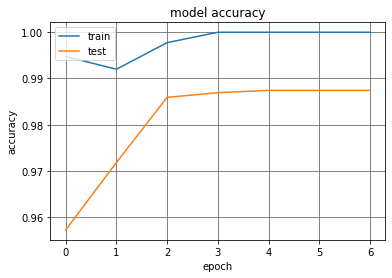

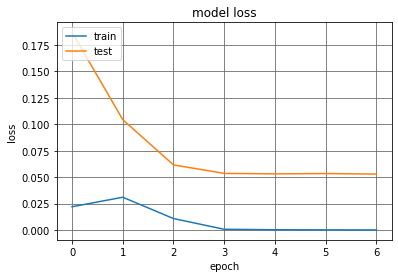

In [48]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

We are able to get over $92\%$ accuracy.

### Evaluate Model

In [49]:
score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 20ms/step - loss: 0.0529 - accuracy: 0.9874
Test loss: 0.05292195454239845
Test accuracy: 0.9874245524406433


### The END

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14801970154698776180, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12022617867685110263
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
!cat /proc/meminfo

MemTotal:       13333568 kB
MemFree:          715424 kB
MemAvailable:   10845036 kB
Buffers:          103536 kB
Cached:          8874188 kB
SwapCached:            0 kB
Active:          3884996 kB
Inactive:        8135156 kB
Active(anon):    1849432 kB
Inactive(anon):    14704 kB
Active(file):    2035564 kB
Inactive(file):  8120452 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              2780 kB
Writeback:             0 kB
AnonPages:       3042532 kB
Mapped:          1486560 kB
Shmem:             15376 kB
Slab:             353772 kB
SReclaimable:     298896 kB
SUnreclaim:        54876 kB
KernelStack:        5216 kB
PageTables:        17012 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666784 kB
Committed_AS:    6385456 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1040 kB
AnonHugePages:   